In [159]:
import json
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = ['Tahoma']
plt.style.use('seaborn-white')  # 'seaborn-ticks'
sns.set_style('white')
import dateutil
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import correlation, pdist, squareform
from scipy.stats import spearmanr, pearsonr, kendalltau
from sklearn.preprocessing import StandardScaler

In [342]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

# rename columns to remove '_RBG', '_FBG' for element-wise subtraction
# rn.columns = rn.columns.str[:-4]
# fn.columns = fn.columns.str[:-4]
# ri.columns = ri.columns.str[:-4]
# fi.columns = fi.columns.str[:-4]
# rd.columns = rd.columns.str[:-4]
# fd.columns = fd.columns.str[:-4]

qval_sampling = data['fdr corrected pval effect of sampling']
qval_gtol = data['fdr corrected pval effect of glucose tolerance']
qval_cross = data['fdr corrected pval effect of interaction sampling and glucose tolerance']
signif_cross_features = data.loc[qval_cross < 0.05].index

In [343]:
fg

,animal,litter,gluc_tol,bg_type,week,ogtt,bg,File Name_lipid,lipid_run_order,fr_name,lipidex_file_number,date,File Name_metab,metab_run_order,fixed_filename,qc_file,blank_file,quant_file
combined_col_name,,,,,,,,,,,,,,,,,,
1076_10_FBG,1076,0,diabetic,FBG,10,2321.25,71.000000,20210729_AJ_Toh_RatBloodGlucose_T1076M_2021040...,7,20210729_AJ_Toh_RatBloodGlucose_T1076M_2021040...,27,4/5/2021,20210831_KAO_HILIC_T1076M_20210405_10wk_FBG,21,20210831_KAO_HILIC_T1076M_20210405_10wk_FBG,False,False,True
1062_8_FBG,1062,0,impaired,FBG,8,1648.75,52.333333,20210729_AJ_Toh_RatBloodGlucose_T1062M_2021032...,8,20210729_AJ_Toh_RatBloodGlucose_T1062M_2021032...,9,3/22/2021,20210831_KAO_HILIC_T1062M_20210322_8wk_FBG,61,20210831_KAO_HILIC_T1062M_20210322_8wk_FBG,False,False,True
1093_9_FBG,1093,2,normal,FBG,9,993.00,64.000000,20210729_AJ_Toh_RatBloodGlucose_T1093M_2021040...,9,20210729_AJ_Toh_RatBloodGlucose_T1093M_2021040...,49,4/2/2021,20210831_KAO_HILIC_T1093M_20210402_9wk_FBG,50,20210831_KAO_HILIC_T1093M_20210402_9wk_FBG,False,False,True
1060_8_RBG,1060,0,impaired,RBG,8,1761.75,225.000000,20210729_AJ_Toh_RatBloodGlucose_T1060M_2021032...,10,20210729_AJ_Toh_RatBloodGlucose_T1060M_2021032...,4,3/25/2021,20210831_KAO_HILIC_T1060M_20210325_8wk_RBG,59,20210831_KAO_HILIC_T1060M_20210325_8wk_RBG,False,False,True
1091_10_FBG,1091,2,normal,FBG,10,846.75,48.500000,20210729_AJ_Toh_RatBloodGlucose_T1091M_2021041...,11,20210729_AJ_Toh_RatBloodGlucose_T1091M_2021041...,39,4/10/2021,20210831_KAO_HILIC_T1091M_20210410_10wk_FBG,56,20210831_KAO_HILIC_T1091M_20210410_10wk_FBG,False,False,True
1092_9_RBG,1092,2,impaired,RBG,9,1377.95,70.500000,20210729_AJ_Toh_RatBloodGlucose_T1092M_2021040...,12,20210729_AJ_Toh_RatBloodGlucose_T1092M_2021040...,44,4/6/2021,20210831_KAO_HILIC_T1092M_20210406_9wk_RBG,18,20210831_KAO_HILIC_T1092M_20210406_9wk_RBG,False,False,True
1093_10_RBG,1093,2,normal,RBG,10,993.00,69.500000,20210729_AJ_Toh_RatBloodGlucose_T1093M_2021041...,13,20210729_AJ_Toh_RatBloodGlucose_T1093M_2021041...,52,4/13/2021,20210831_KAO_HILIC_T1093M_20210413_10wk_RBG,45,20210831_KAO_HILIC_T1093M_20210413_10wk_RBG,False,False,True
1082_10_FBG,1082,1,diabetic,FBG,10,2224.75,50.000000,20210729_AJ_Toh_RatBloodGlucose_T1082M_2021040...,14,20210729_AJ_Toh_RatBloodGlucose_T1082M_2021040...,33,4/5/2021,20210831_KAO_HILIC_T1082M_20210405_10wk_FBG,41,20210831_KAO_HILIC_T1082M_20210405_10wk_FBG,False,False,True
1060_9_RBG,1060,0,impaired,RBG,9,1761.75,83.000000,20210729_AJ_Toh_RatBloodGlucose_T1060M_2021040...,15,20210729_AJ_Toh_RatBloodGlucose_T1060M_2021040...,6,4/1/2021,20210831_KAO_HILIC_T1060M_20210401_9wk_RBG,5,20210831_KAO_HILIC_T1060M_20210401_9wk_RBG,False,False,True


In [117]:
kendall = pd.read_csv(r'..\data\processed\combined_metab_lipid_kendall_correlation.csv', index_col=0)
pearson = pd.read_csv(r'..\data\processed\combined_metab_lipid_pearson_correlation.csv', index_col=0)

,m_0,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,...,l_1019,l_1020,l_1021,l_1022,l_1023,l_1024,l_1025,l_1026,l_1027,l_1028
new_index,,,,,,,,,,,,,,,,,,,,,
m_0,1.000000,-0.124301,0.159910,-0.104983,-0.162021,0.071184,-0.189954,0.274699,0.195287,-0.146373,...,0.067402,0.049546,0.059779,0.180015,0.128689,-0.081822,0.067421,-0.007076,-0.107835,0.080578
m_1,-0.124301,1.000000,0.142833,0.870663,0.111603,-0.322109,0.824972,-0.000838,0.259686,0.531982,...,0.128447,0.164841,0.114900,0.213138,0.280608,0.737576,0.200909,0.733629,0.701777,0.122921
m_2,0.159910,0.142833,1.000000,-0.138230,-0.062777,0.471939,-0.092942,0.318709,0.748335,-0.257648,...,0.522574,0.500229,0.497010,0.378563,0.389552,-0.017794,0.394825,-0.047330,-0.167331,0.466333
m_3,-0.104983,0.870663,-0.138230,1.000000,-0.015648,-0.617870,0.900745,0.013951,-0.046681,0.773909,...,-0.181877,-0.144128,-0.180917,0.004151,0.044978,0.779378,-0.052970,0.807270,0.847960,-0.158562
m_4,-0.162021,0.111603,-0.062777,-0.015648,1.000000,0.468915,-0.114325,0.134512,-0.063320,-0.144188,...,-0.129331,-0.115791,-0.116307,-0.218930,-0.124043,-0.114640,-0.099739,-0.155188,-0.132737,-0.100399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l_1024,-0.081822,0.737576,-0.017794,0.779378,-0.114640,-0.520869,0.715307,0.087287,0.017439,0.639438,...,0.227210,0.248438,0.244305,0.385977,0.463488,1.000000,0.348528,0.979102,0.929693,0.264366
l_1025,0.067421,0.200909,0.394825,-0.052970,-0.099739,0.347973,-0.139414,0.055522,0.400060,-0.300042,...,0.931121,0.841953,0.933117,0.860878,0.942346,0.348528,1.000000,0.306305,0.044191,0.938791
l_1026,-0.007076,0.733629,-0.047330,0.807270,-0.155188,-0.582441,0.732688,0.062737,0.001895,0.677992,...,0.166336,0.184926,0.183143,0.379721,0.426104,0.979102,0.306305,1.000000,0.940486,0.206349


## Make df with 20 groups, averaging within each week's sampling type

In [4]:
order_cols = rn.columns.to_list() + fn.columns.to_list() + \
                ri.columns.to_list() + fi.columns.to_list() + \
                rd.columns.to_list() + fd.columns.to_list()

# Standardize data
data.loc[:, data_cols] = StandardScaler().fit_transform(data.loc[:, data_cols])
# data.loc[:, data_cols]

# Make file grouping - Heat Map File Grouping
hmfg = fg.set_index('combined_col_name')[['animal', 'bg_type']].T
# Make another file grouping
hmfg2 = fg[['animal', 'bg_type', 'gluc_tol']].drop_duplicates().set_index(['bg_type', 'animal'])

d = data.loc[:, order_cols].append(hmfg).T
d = d.groupby(['bg_type', 'animal']).mean()
d = d.join(hmfg2)

# Set metadata as indexes
d.set_index('gluc_tol', append=True, inplace=True)
d.sort_values(['bg_type', 'gluc_tol', 'animal'], ascending=[True, False, True], inplace=True)
d

l_0       l_1       l_2       l_3       l_4  \
bg_type animal gluc_tol                                                     
FBG     1091   normal    0.658193  0.944542  0.718667  1.972213  0.072298   
        1093   normal    0.582896  1.088961  0.595267  1.983369  0.257411   
        1060   impaired  0.627583  1.177346  0.745092  2.021367  0.467008   
        1062   impaired  0.517778  0.992269  0.571426  1.966271  0.267027   
        1074   impaired  0.420240  0.890599  0.726746  2.090372  0.179301   
        1092   impaired  0.521512  1.083607  0.619972  1.991530  0.273998   
        1102   impaired  0.549985  1.088480  0.698838  1.882185  0.255397   
        1076   diabetic  0.263949  0.615316  0.430176  1.650632 -0.224592   
        1082   diabetic  0.649759  1.178083  0.880686  2.024017  0.244519   
        1101   diabetic  0.531250  1.107757  0.756140  1.986287  0.348034   
RBG     1091   normal    0.887272  1.247744  0.688818  2.160258  0.350685   
        1093   normal    0.688521  1.064403  0.821354  2.009488  0.355518   
        1060   impaired  0.725860  1.206625  0.813709  1.947588  0.444065   
        1062   impaired  0.403773  0.579232  0.637179  2.021118  0.270295   
        1074   impaired  0.748465  1.193252  0.817260  2.133756  0.481352   
        1092   impaired  0.828251  1.204344  0.867798  2.053171  0.266172   
        1102   impaired  0.473955  0.674217  0.556168  1.955514  0.134988   
        1076   diabetic  0.503930  0.767384  0.796187  1.871793  0.301450   
        1082   diabetic  0.505727  0.876875  0.596706  1.971974  0.208802   
        1101   diabetic  0.600213  1.072227  0.677169  2.120861  0.275077   

                              l_5       l_6       l_7       l_8       l_9  \
bg_type animal gluc_tol                                                     
FBG     1091   normal    1.732007  3.290954  0.195351  1.716719  0.922611   
        1093   normal    1.820602  3.192389  0.182152  1.571707  0.705476   
        1060   impaired  1.949313  3.329612  0.172992  1.645939  0.827470   
        1062   impaired  1.650971  3.199877  0.081931  1.571126  0.628333   
        1074   impaired  1.745678  3.290150  0.154130  1.645689  0.720403   
        1092   impaired  1.828682  3.159777  0.153252  1.551269  0.651968   
        1102   impaired  1.839403  3.330699 -0.164134  1.612565  0.572181   
        1076   diabetic  1.474347  3.043705 -0.247896  1.431097  0.346336   
        1082   diabetic  1.816268  3.218756  0.282643  1.674557  0.865110   
        1101   diabetic  1.899387  3.182927  0.085577  1.566378  0.746925   
RBG     1091   normal    1.800076  3.193886  0.233039  1.625315  0.645788   
        1093   normal    1.742154  3.093593  0.129437  1.504082  0.624608   
        1060   impaired  1.797370  3.373536  0.019501  1.648350  0.628866   
        1062   impaired  1.457778  3.175050  0.066305  1.561007  0.514992   
        1074   impaired  1.891247  3.274192  0.093073  1.611810  0.691187   
        1092   impaired  1.876388  3.211296  0.179391  1.634891  0.766959   
        1102   impaired  1.666232  3.027925 -0.027558  1.379658  0.305270   
        1076   diabetic  1.740561  3.150770 -0.114839  1.559948  0.600895   
        1082   diabetic  1.614873  3.145254 -0.106932  1.443070  0.303848   
        1101   diabetic  1.786211  3.139131  0.187285  1.534844  0.460442   

                         ...     m_682     m_368     m_340     m_616  \
bg_type animal gluc_tol  ...                                           
FBG     1091   normal    ... -0.539483  0.410606  0.453191 -0.472971   
        1093   normal    ... -0.651428  0.308930  0.339819 -0.754844   
        1060   impaired  ... -0.727322  0.196547  0.218683 -1.007176   
        1062   impaired  ... -0.864268  0.165062  0.180189 -1.032448   
        1074   impaired  ... -0.540860  0.349850  0.403390 -0.795858   
        1092   impaired  ... -0.690295  0.278217  0.291666 -0.827747   
        1102   impaired  ... -0.733837  0.220646  0.275036 -1.08

## Make row colors

In [5]:
lm_class = data.loc[:, ['Compound Class', 'Type']]
lm_class.loc[:, 'd'] = lm_class['Compound Class'].map(colors)
lm_class.loc[:, 'type_color'] = lm_class['Type'].map(colors)
lm_class.loc[:, 'superclass_color'] = lm_class['d'].str['color']
lm_class.loc[:, 'superclass'] = lm_class['d'].str['superclass']
lm_class.drop('d', inplace=True, axis=1)
lm_class

,Compound Class,Type,type_color,superclass_color,superclass
i,,,,,
l_0,unknown,lipid,"[0.4, 0.7607843137254902, 0.6470588235294118]","[0.4980392156862745, 0.4980392156862745, 0.498...",Unidentified
l_1,unknown,lipid,"[0.4, 0.7607843137254902, 0.6470588235294118]","[0.4980392156862745, 0.4980392156862745, 0.498...",Unidentified
l_2,unknown,lipid,"[0.4, 0.7607843137254902, 0.6470588235294118]","[0.4980392156862745, 0.4980392156862745, 0.498...",Unidentified
l_3,unknown,lipid,"[0.4, 0.7607843137254902, 0.6470588235294118]","[0.4980392156862745, 0.4980392156862745, 0.498...",Unidentified
l_4,unknown,lipid,"[0.4, 0.7607843137254902, 0.6470588235294118]","[0.4980392156862745, 0.4980392156862745, 0.498...",Unidentified
...,...,...,...,...,...
m_169,unknown,metabolite,"[0.9882352941176471, 0.5529411764705883, 0.384...","[0.4980392156862745, 0.4980392156862745, 0.498...",Unidentified
m_213,unknown,metabolite,"[0.9882352941176471, 0.5529411764705883, 0.384...","[0.4980392156862745, 0.4980392156862745, 0.498...",Unidentified
m_24,CA,metabolite,"[0.9882352941176471, 0.5529411764705883, 0.384...","[0.5490196078431373, 0.33725490196078434, 0.29...",Carboxylic Acid


## Make column colors 

In [6]:
bg_type_color = []
gluc_tol_color = []
for bg, animal, gluc_tol in d.index:
    bg_type_color.append(colors[bg])
    gluc_tol_color.append(colors[gluc_tol])
col_colors = [bg_type_color, gluc_tol_color]

In [ ]:
no_unknowns = data['Proposed ID'] != 'unknown'
signif_sampling = data['fdr corrected pval effect of sampling'] < 0.05
quick_render_test = data['RT [min]'] < 0.6
all_features = pd.Series([True] * len(d))

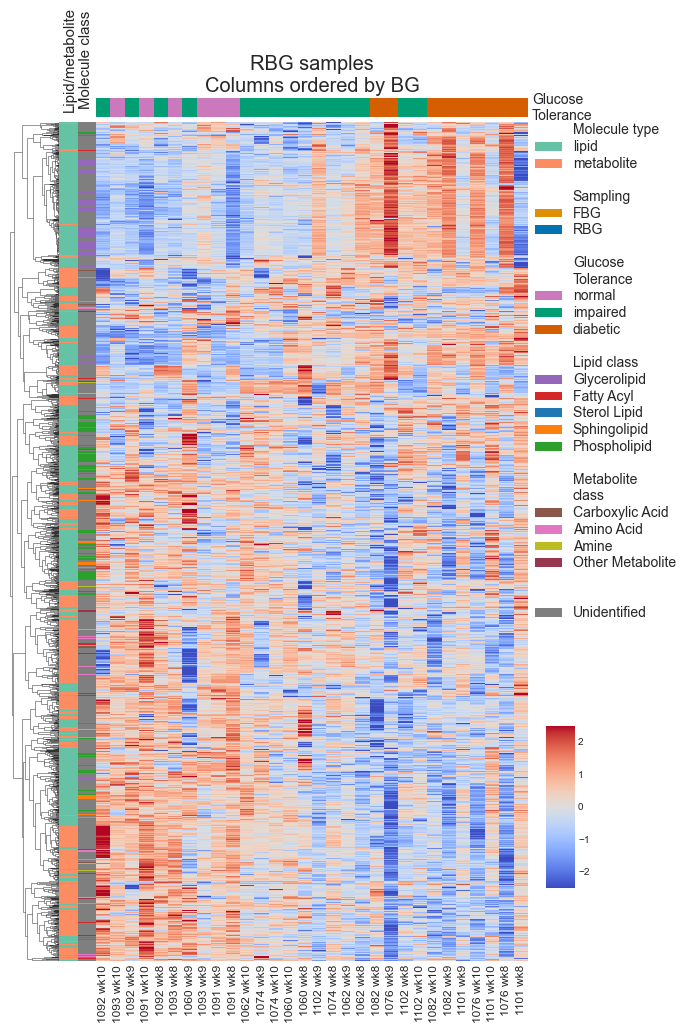

In [70]:
# sort by RBG value
rbg_sort = fg.loc[fg['bg_type'] == 'RBG', ['combined_col_name', 'bg']].sort_values('bg')['combined_col_name'].to_list()
rbg_values = fg.loc[fg['bg_type'] == 'RBG', 'bg'].sort_values().astype('int').to_list()

no_unknowns = data['Proposed ID'] != 'unknown'
features = data.index  # quick_render_test
cm = sns.clustermap(
    data=data.loc[features, rbg_sort],
    z_score=0,  # Z score the rows with 0 (because z-score columns makes columns look very homogeneous)
#     row_linkage=my_row_cluster,  
#     col_linkage=my_col_cluster,
    method='complete',     # complete, ward, single, average
    metric='correlation',  # cosine, correlation, euclidean
#     robust=True,
    vmin=-2.5, vmax=2.5,
    row_colors=[lm_class.loc[features, 'type_color'], lm_class['superclass_color'][features]],
    col_colors=[colors[animal_tol[int(animal[:4])]] for animal in data.loc[:, rbg_sort].columns],
    cmap='coolwarm',  # coolwarm turbo viridis seismic vlag VLAG IS GOOD twilight TWILIGHT IS GOOD
    col_cluster=False,
#     figsize=(11, 12),
    cbar_pos=(0.95, 0.18, 0.05, 0.15),
    dendrogram_ratio=(0.1, 0.08),
    colors_ratio=(0.035, 0.02),
)
fig = cm.fig
cbar = cm.ax_cbar
hm = cm.ax_heatmap
dg = cm.ax_row_dendrogram
cc = cm.ax_col_colors
rc = cm.ax_row_colors

fig.set_size_inches(8, 15)
fig.set_facecolor('white')

hm.set_yticklabels([])
xtl = hm.get_xticklabels()
new_xtl = [text.get_text()[:-4].replace('_', ' wk') for text in xtl]
hm.set_xticklabels(new_xtl, rotation=90, 
#                    ha='right', va='top', 
                   fontsize=12)
hm.set_ylabel('')
keys = list(colors.keys())
labels = [name for name in keys[:17]]
handles = [Patch(facecolor=colors[label]) for label in labels]
legend_categories = ['Molecule type', '\nSampling', '\nGlucose\nTolerance', '\nLipid class', '\nMetabolite\nclass', '\n']
for divider, category in zip([0, 3, 6, 10, 16, 21], legend_categories): 
    handles.insert(divider, Patch(edgecolor='white', facecolor='white', alpha=0))
    labels.insert(divider, category)
hm.legend(handles, labels, loc=(1, 0.4), fontsize=14, labelspacing=0.2)
rc.set_title('Lipid/metabolite\nMolecule class', 
             fontsize=15, rotation='vertical', 
#              loc=(0.5, 0.5),
             horizontalalignment='center', verticalalignment='bottom',
             pad=10)
cc.yaxis.set_label_position('right')
cc.set_ylabel('Glucose\nTolerance', 
#               loc='bottom',
              ha='left', va='center',
              rotation='horizontal', fontsize=14)
cc.set_title('RBG samples\nColumns ordered by BG', fontsize=20)

# Annotate column colorbar with RBG value
# for rbg_value, cc_x in zip(rbg_values, range(len(rbg_values))):
#     cc.annotate(rbg_value, xy=(cc_x + 0.3, 0.65), fontsize=8)
print('')

## Two heatmaps, RBG vs FBG samples
1. 30 columns each
2. cluster samples within each heatmap
3. Try sharing feature clusters across heatmaps
4. Center each df individually to the mean of the normal samples
5. do not Z-score, do not divide by .std()
6. Try both (1 - pearson) and (1 - kendall) distances
    1. Also try 1 - abs(pearson/kendall)

In [161]:
# re-read in data (because it might be StandardScale() transformed above)
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')

# A few rows were filtered between the final data and the kendall/pearson correlation dataframes
pearson = pearson.loc[data.index, data.index]
kendall = kendall.loc[data.index, data.index]

pearson_dist = squareform(1 - pearson)
kendall_dist = squareform(1 - kendall)
kendall_dist

array([0.5220339 , 0.66101695, 0.6440678 , ..., 0.11977401, 0.24858757,
       0.25988701])

In [172]:
f.sub(fn_mean, axis=0)

,1076_10_FBG,1062_8_FBG,1093_9_FBG,1091_10_FBG,1082_10_FBG,1101_9_FBG,1074_10_FBG,1076_9_FBG,1092_9_FBG,1074_8_FBG,...,1102_9_FBG,1093_10_FBG,1101_8_FBG,1102_8_FBG,1082_8_FBG,1076_8_FBG,1091_8_FBG,1092_10_FBG,1102_10_FBG,1074_9_FBG
i,,,,,,,,,,,,,,,,,,,,,
l_0,-3.104431,-0.196674,-0.291087,0.792570,-0.121810,-0.046029,-0.154239,0.584847,-0.167799,0.074258,...,-0.010601,-0.396511,0.135321,0.019256,-0.205407,0.029297,-0.142036,-1.047537,-0.346367,-1.393252
l_1,-2.987787,0.064792,-0.146284,0.900859,0.174841,0.413370,0.578844,0.938264,0.089844,0.687386,...,0.401594,0.138726,0.131640,0.323737,0.315396,-0.732715,0.373355,0.142414,-0.135867,-2.272677
l_2,-2.931316,0.134080,-0.558431,0.445502,0.488694,0.413685,0.026649,0.841654,0.200119,0.593080,...,0.272725,0.084026,0.154568,0.143357,0.502430,0.608188,-0.263635,-0.144538,0.083814,-0.069657
l_3,-2.551437,-0.140704,-0.243605,0.361287,0.278063,0.174285,0.493143,0.466950,0.451849,0.476736,...,-0.020996,0.194847,-0.148994,-0.680863,-0.297990,-0.041442,0.237334,0.258301,-0.146370,-0.313964
l_4,-2.973065,0.357918,-0.629284,-0.030590,0.527035,0.351531,0.198117,0.372741,0.529889,0.129795,...,0.685487,0.393329,0.713491,0.158854,-0.021776,-0.180716,0.476173,0.250457,0.133918,-0.115637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m_169,-0.241707,-0.518394,0.363981,-0.175228,-0.272041,-0.297516,-0.499577,-0.685511,-0.119828,-0.369181,...,-0.028705,-0.052326,-0.339390,-0.151633,-0.310455,-0.378824,0.002055,-0.181466,-0.056641,-0.335375
m_213,-0.033868,0.338583,-1.383655,-1.527437,1.087333,-1.885740,-2.586425,-3.217062,-1.329920,2.035299,...,-1.401052,1.150279,-4.139834,1.106236,-0.254652,1.287999,-1.698624,-0.480657,-0.301293,-0.042736
m_24,-0.203482,0.160499,-0.369118,-0.261258,0.133495,-0.381157,-0.290884,-1.138080,-0.290049,0.512004,...,-0.346034,-0.026473,-1.242499,0.168721,-0.173003,0.193565,-0.205320,-0.068813,0.057627,-0.007064


In [223]:
fn.filter('1091_9_FBG').columns

Index([], dtype='object')

In [226]:
fn.drop('1091_9_FBG', axis=1).mean(axis=1)

i
l_0      23.543425
l_1      24.833345
l_2      23.502868
l_3      27.014856
l_4      22.549770
           ...    
m_169    25.112866
m_213    20.179988
m_24     27.110382
m_505    20.518146
m_441    22.068542
Length: 1727, dtype: float64

In [257]:
fn

,1093_9_FBG,1091_10_FBG,1093_8_FBG,1091_9_FBG,1093_10_FBG,1091_8_FBG
i,,,,,,
l_0,23.218699,24.302356,23.715048,23.341587,23.113274,23.367750
l_1,24.375151,25.422294,24.814330,22.961884,24.660162,24.894790
l_2,23.038733,24.042666,23.418223,24.068642,23.681190,23.333529
l_3,26.708762,27.313654,26.714948,26.639924,27.147215,27.189702
l_4,21.722467,22.321161,23.132217,21.361656,22.745079,22.827924
...,...,...,...,...,...,...
m_169,25.488336,24.949127,24.928428,25.181802,25.072029,25.126410
m_213,19.581065,19.437282,20.500498,24.888377,22.114998,19.266095
m_24,26.936184,27.044044,27.192872,28.279901,27.278829,27.099982


In [258]:
# Calculate mean of each feature from the normal columns
# fn_mean = fn.mean(axis=1)
# rn_mean = rn.mean(axis=1)

# Drop the 1091 normal Fasted Week 9 outlier: 
# fn_mean = fn.drop('1091_9_FBG', axis=1).mean(axis=1)

# Use only week 8 Fasted Normal for mean values
fn_mean = data.loc[:, ['1091_8_FBG', '1093_8_FBG']].mean(axis=1)

# because we need to keep the centers the same on both plots (based on fasted values), 
#    subtract both matrices by the same fn_mean
fbg_mean_centered = f.sub(fn_mean, axis=0)
rbg_mean_centered = r.sub(fn_mean, axis=0)

# With means, the heatmap is very hot. Try with median
fn_median = fn.median(axis=1)
fbg_median_centered = f.sub(fn_median, axis=0)
rbg_median_centered = r.sub(fn_median, axis=0)

In [ ]:
linkage(pearson_dist.loc[features, features], method='complete')

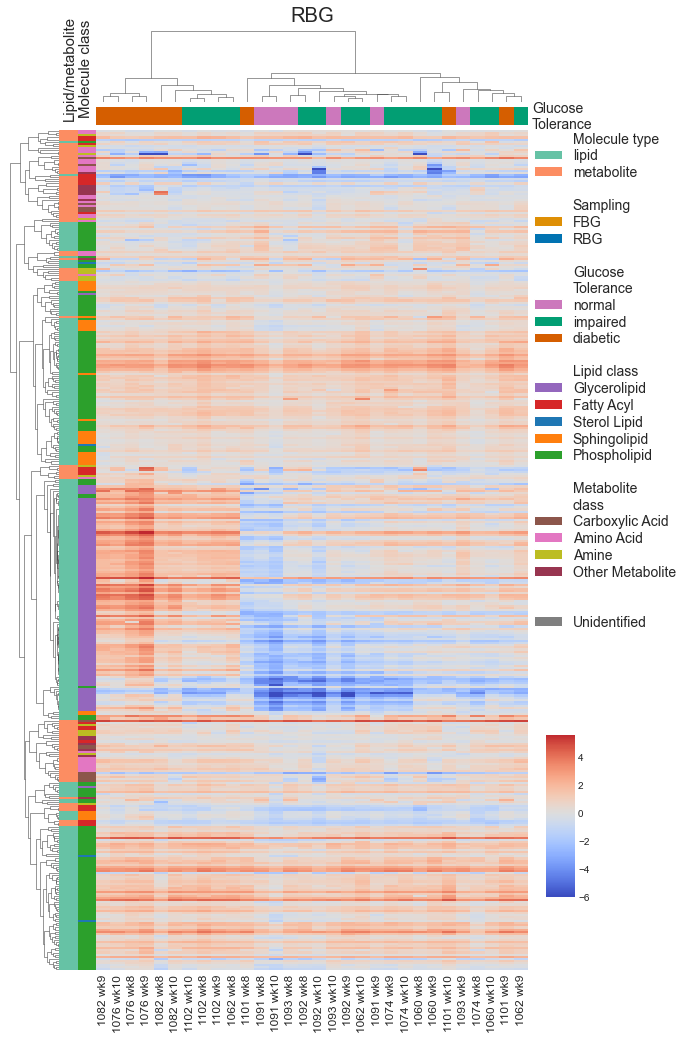

In [229]:
# sort by RBG value

no_unknowns = data['Proposed ID'] != 'unknown'
features = no_unknowns # data.index

def make_cm(data, cols, features, row_linkage=None, col_linkage=None):
    cm = sns.clustermap(
        data=data.loc[features, cols],
        method='complete',     # complete, ward, single, average
        metric='correlation',  # cosine, correlation, euclidean
        row_linkage=row_linkage, col_linkage=col_linkage,
        row_colors=[lm_class.loc[features, 'type_color'], lm_class['superclass_color'][features]],
        col_colors=[colors[animal_tol[int(animal[:4])]] for animal in data.loc[:, cols].columns],
        cmap='coolwarm',  # coolwarm turbo viridis seismic vlag twilight VLAG=GOOD
        center=0, vmin=-6,
        col_cluster=True,
        cbar_pos=(0.95, 0.18, 0.05, 0.15),
        dendrogram_ratio=(0.1, 0.08),
        colors_ratio=(0.035, 0.02),
    )
    fig = cm.fig
    cbar = cm.ax_cbar
    hm = cm.ax_heatmap
    rd, cd = cm.ax_row_dendrogram, cm.ax_col_dendrogram
    cc, rc = cm.ax_col_colors, cm.ax_row_colors
    
    fig.set_size_inches(8, 15)
    fig.set_facecolor('white')

    hm.set_yticklabels([])
    xtl = hm.get_xticklabels()
    new_xtl = [text.get_text()[:-4].replace('_', ' wk') for text in xtl]
    hm.set_xticklabels(new_xtl, rotation=90, 
    #                    ha='right', va='top', 
                       fontsize=12)
    hm.set_ylabel('')
    keys = list(colors.keys())
    labels = [name for name in keys[:17]]
    handles = [Patch(facecolor=colors[label]) for label in labels]
    legend_categories = ['Molecule type', '\nSampling', '\nGlucose\nTolerance', '\nLipid class', '\nMetabolite\nclass', '\n']
    for divider, category in zip([0, 3, 6, 10, 16, 21], legend_categories): 
        handles.insert(divider, Patch(edgecolor='white', facecolor='white', alpha=0))
        labels.insert(divider, category)
    hm.legend(handles, labels, loc=(1, 0.4), fontsize=14, labelspacing=0.2)
    rc.set_title('Lipid/metabolite\nMolecule class', 
                 fontsize=15, rotation='vertical', 
    #              loc=(0.5, 0.5),
                 horizontalalignment='center', verticalalignment='bottom',
                 pad=10)
    cc.yaxis.set_label_position('right')
    cc.set_ylabel('Glucose\nTolerance', ha='left', va='center', rotation='horizontal', fontsize=14)
    cd.set_title(('RBG' if 'RBG' in cols[0] else 'FBG'), fontsize=20)
    # Annotate column colorbar with RBG value
    # for rbg_value, cc_x in zip(rbg_values, range(len(rbg_values))):
    #     cc.annotate(rbg_value, xy=(cc_x + 0.3, 0.65), fontsize=8)
    return cm
rbg_cm = make_cm(rbg_mean_centered, rbg_cols, features)
rbg_row_linkage = rbg_cm.dendrogram_row.calculated_linkage
rbg_col_linkage = rbg_cm.dendrogram_col.calculated_linkage

C:\Users\bjanderson23\anaconda3\lib\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


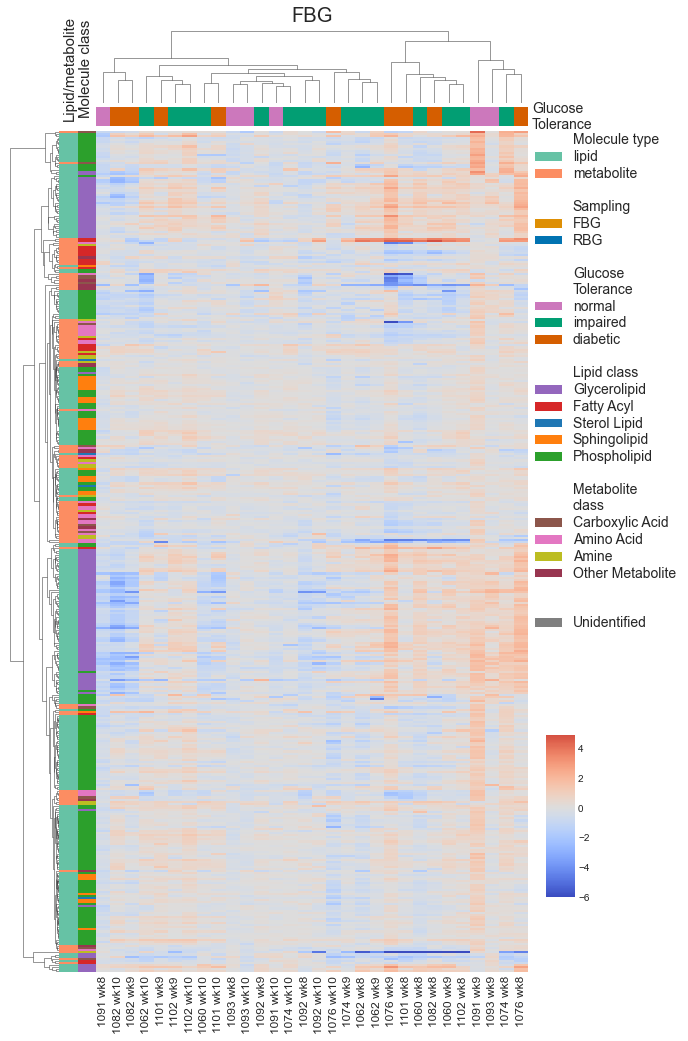

In [214]:
make_cm(fbg_mean_centered, fbg_cols, features, row_linkage=rbg_row_linkage)

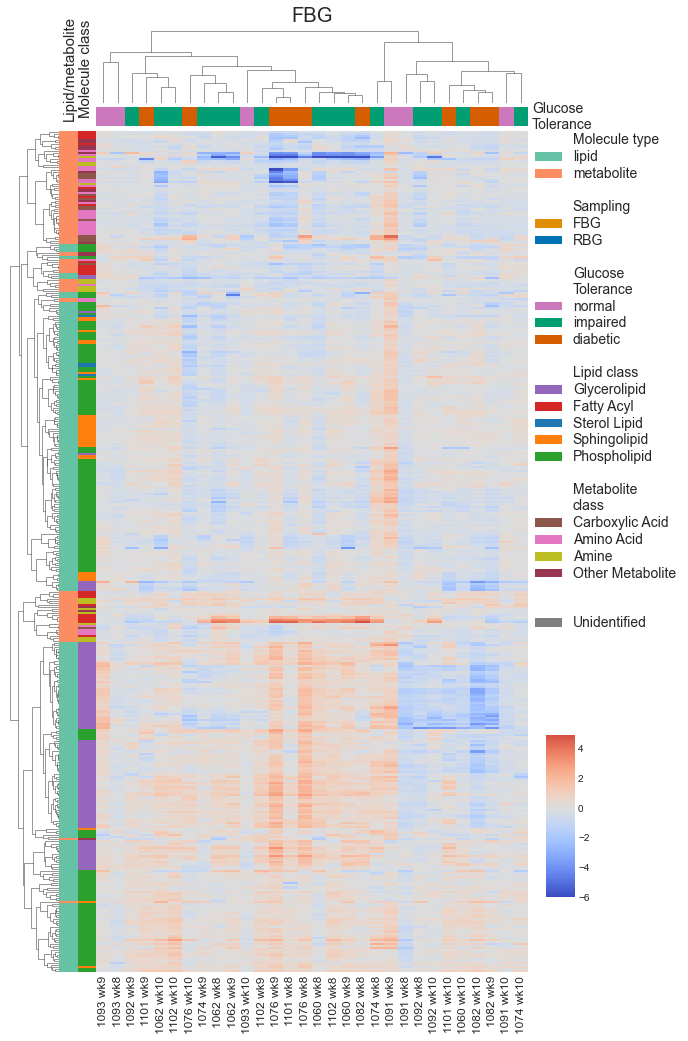

In [202]:
make_cm(fbg_mean_centered, fbg_cols, features)

In [ ]:
pd.Series.map

In [321]:
fg['ogtt'] = fg['animal'].map(lambda x: ap.loc[x, 'OGTT (AUC)'])
order_by_animal_week = fg.sort_values(
    ['bg_type', 'gluc_tol', 'animal', 'ogtt', 'week', ], 
    ascending=[True, False, True, True, True]).index
order_by_animal_week

Index(['1091_8_FBG', '1091_9_FBG', '1091_10_FBG', '1093_8_FBG', '1093_9_FBG',
       '1093_10_FBG', '1060_8_FBG', '1060_9_FBG', '1060_10_FBG', '1062_8_FBG',
       '1062_9_FBG', '1062_10_FBG', '1074_8_FBG', '1074_9_FBG', '1074_10_FBG',
       '1092_8_FBG', '1092_9_FBG', '1092_10_FBG', '1102_8_FBG', '1102_9_FBG',
       '1102_10_FBG', '1076_8_FBG', '1076_9_FBG', '1076_10_FBG', '1082_8_FBG',
       '1082_9_FBG', '1082_10_FBG', '1101_8_FBG', '1101_9_FBG', '1101_10_FBG',
       '1091_8_RBG', '1091_9_RBG', '1091_10_RBG', '1093_8_RBG', '1093_9_RBG',
       '1093_10_RBG', '1060_8_RBG', '1060_9_RBG', '1060_10_RBG', '1062_8_RBG',
       '1062_9_RBG', '1062_10_RBG', '1074_8_RBG', '1074_9_RBG', '1074_10_RBG',
       '1092_8_RBG', '1092_9_RBG', '1092_10_RBG', '1102_8_RBG', '1102_9_RBG',
       '1102_10_RBG', '1076_8_RBG', '1076_9_RBG', '1076_10_RBG', '1082_8_RBG',
       '1082_9_RBG', '1082_10_RBG', '1101_8_RBG', '1101_9_RBG', '1101_10_RBG'],
      dtype='object', name='combined_col_name')

In [300]:
data.index[no_unknowns]

Index(['l_59', 'l_62', 'l_66', 'l_68', 'l_69', 'l_73', 'l_74', 'l_76', 'l_81',
       'l_83',
       ...
       'm_193', 'm_88', 'm_387', 'm_362', 'm_125', 'm_480', 'm_90', 'm_368',
       'm_340', 'm_24'],
      dtype='object', name='i', length=402)

In [302]:
signif_cross_features.intersection(ids)

Index(['l_210', 'l_230', 'l_262', 'l_352', 'l_360', 'l_442', 'l_479', 'l_496',
       'l_505', 'l_506',
       ...
       'm_1', 'm_50', 'm_538', 'm_110', 'm_167', 'm_406', 'm_488', 'm_70',
       'm_88', 'm_125'],
      dtype='object', name='i', length=117)

In [306]:
fg.loc[fg['combined_col_name'] == '1091_8_FBG']

,File Name_lipid,lipid_run_order,fr_name,animal,bg_type,quant_file,week,lipidex_file_number,date,glucose_tolerance,bg,File Name_metab,metab_run_order,fixed_filename,qc_file,blank_file,gluc_tol,combined_col_name
49,20210729_AJ_Toh_RatBloodGlucose_T1091M_2021032...,56,20210729_AJ_Toh_RatBloodGlucose_T1091M_2021032...,1091,FBG,True,8,35,2021-03-27,normal,53.333333,20210831_KAO_HILIC_T1091M_20210327_8wk_FBG,63,20210831_KAO_HILIC_T1091M_20210327_8wk_FBG,False,False,normal,1091_8_FBG


C:\Users\bjanderson23\anaconda3\lib\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 432x288 with 0 Axes>

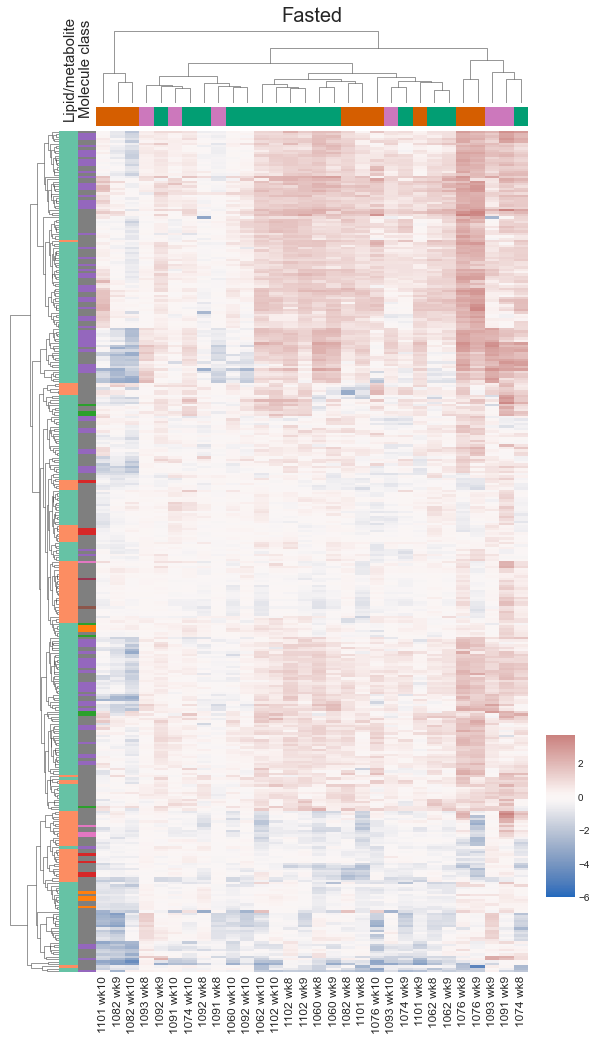

<Figure size 432x288 with 0 Axes>

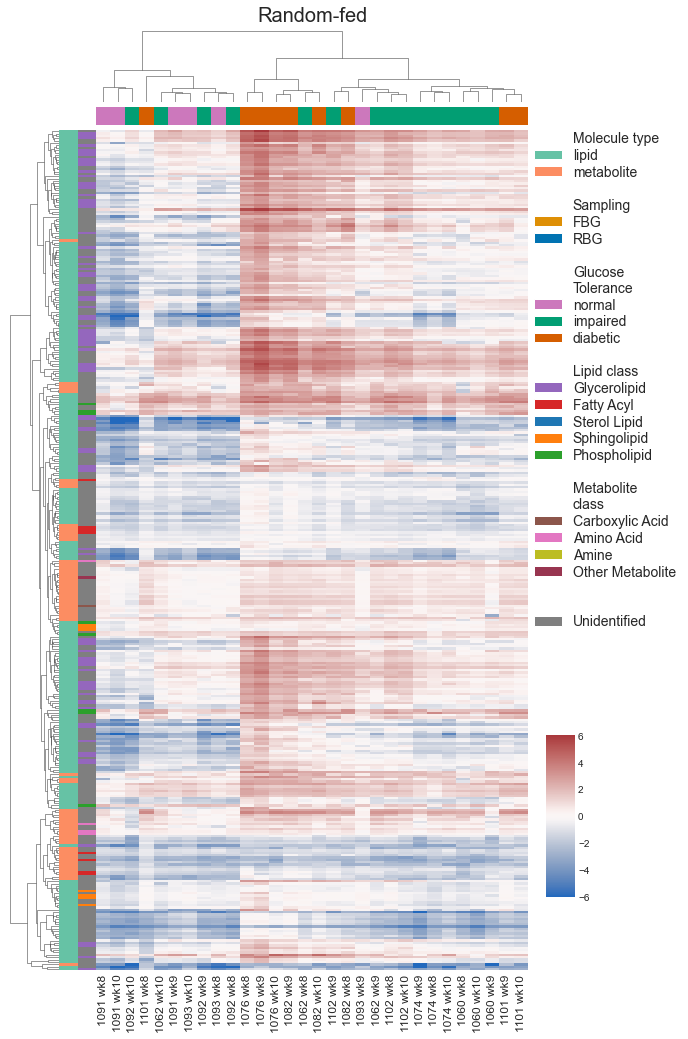

In [307]:
# sort by RBG value
ids = data.loc[data['Proposed ID'] != 'unknown'].index
no_unknowns = data['Proposed ID'] != 'unknown'
features = no_unknowns # data.index

def make_cm(data1, data2, features, col_cluster=True):
    cm1_row_linkage = None
    cm1_col_linkage = None
    for data, index in zip([data1, data2], [1, 2]):
        bg_type = 'RBG' if 'RBG' in data.columns[0] else 'FBG'
        fig = plt.figure()
        
#         col_colors = [
            
#         ]
        
        cm = sns.clustermap(
            data=data.loc[features],
            method='complete',     # complete, ward, single, average
            metric='euclidean',  # cosine, correlation, euclidean
            row_linkage=(None if index == 1 else ax1_row_linkage), 
            col_linkage=None,  # (None if index == 1 else ax1_col_linkage),
            row_colors=[lm_class.loc[features, 'type_color'], lm_class['superclass_color'][features]],
            col_colors=[colors[animal_tol[int(animal[:4])]] for animal in data.columns],
            cmap='vlag',  # coolwarm turbo viridis seismic vlag twilight VLAG=GOOD
            center=0, vmin=-6,
            col_cluster=col_cluster,
#             cbar=(True if index==2 else False),
            cbar_pos=(0.95, 0.18, 0.05, 0.15),
            dendrogram_ratio=(0.1, 0.08),
            colors_ratio=(0.035, 0.02),
        )        
        fig = cm.fig
        fig.set_size_inches(8, 15)
        fig.set_facecolor('white')
        hm = cm.ax_heatmap
        rd, cd = cm.ax_row_dendrogram, cm.ax_col_dendrogram
        cc, rc = cm.ax_col_colors, cm.ax_row_colors
        
        hm.set_ylabel('')   
        hm.set_yticklabels([])
        new_xtl = [text.get_text()[:-4].replace('_', ' wk') for text in hm.get_xticklabels()]
        hm.set_xticklabels(new_xtl, rotation=90, fontsize=12)
        
        ## Things only in 1st heatmap
        if index == 1:
            ax1_row_linkage = cm.dendrogram_row.calculated_linkage
#             ax1_col_linkage = cm.dendrogram_col.calculated_linkage
            rc.set_title('Lipid/metabolite\nMolecule class', 
                         fontsize=15, rotation='vertical', ha='center', va='bottom', pad=10)
        ## Things only in 2nd heatmap
        if index == 2:
            keys = list(colors.keys())
            labels = [name for name in keys[:17]]
            handles = [Patch(facecolor=colors[label]) for label in labels]
            legend_categories = ['Molecule type', '\nSampling', '\nGlucose\nTolerance', '\nLipid class', '\nMetabolite\nclass', '\n']
            for divider, category in zip([0, 3, 6, 10, 16, 21], legend_categories): 
                handles.insert(divider, Patch(edgecolor='white', facecolor='white', alpha=0))
                labels.insert(divider, category)
            hm.legend(handles, labels, loc=(1, 0.4), fontsize=14, labelspacing=0.2)
            cc.yaxis.set_label_position('right')
#             cc.set_ylabel('Glucose\nTolerance', ha='left', va='center', rotation='horizontal', fontsize=14)
        cd.set_title(('Random-fed' if bg_type == 'RBG' else 'Fasted'), fontsize=20)
#         fig.savefig(f'..\\reports\\figures\\4-3-2\\{bg_type}_clustermap.svg')

fbg_order = order_by_animal_week[:30]
rbg_order = order_by_animal_week[30:]
make_cm(fbg_mean_centered.loc[:, fbg_order],
        rbg_mean_centered.loc[:, rbg_order],  
        features=signif_cross_features,  # .intersection(ids),
        col_cluster=True)